# Prediction of Titanic Survivals

The aim of the notebook is to build a machine learning model for prediction the chances of survival based on Titanic dataset.

Data covers demographic information such as sex, age, number of family members onboard as well as information about ticket fare, class, cabin and embarking port.

<img src="https://insidearabia.com/wp-content/uploads/2019/04/The-Titanic-My-Grandfather’s-Unsinkable-Memories-3-e1556531238178-980x640.jpg" width="400" height="200">

#### Importing libraries

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

#### Loading data

In [2]:
train = pd.read_csv('./train.csv', index_col=0)
test = pd.read_csv('./test.csv', index_col=0)
train.shape, test.shape

((891, 11), (418, 10))

In [3]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Checking missing data

In [3]:
missing_val_count_by_column_train = (train.isnull().sum())
missing_val_count_by_column_train[missing_val_count_by_column_train>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [4]:
missing_val_count_by_column_test = (test.isnull().sum())
missing_val_count_by_column_test[missing_val_count_by_column_test>0]

Age       86
Fare       1
Cabin    327
dtype: int64

Cabin is variable with over 50% of nulls, so I decide to remove it from the analysis.

In [5]:
train.drop('Cabin', inplace=True, axis=1)
test.drop('Cabin', inplace=True, axis=1)

#### Exploratory data analysis

In [7]:
train.groupby(['Pclass','Survived'])['Name'].count().unstack()

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [8]:
train.groupby(['Sex','Survived'])['Name'].count().unstack()

Survived,0,1
Sex,,
female,81,233
male,468,109


In [88]:
train.groupby(['Embarked','Survived'])['Name'].count().unstack()

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


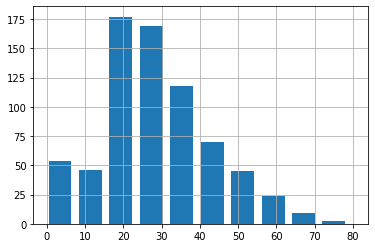

In [9]:
import matplotlib.pyplot as plt
train["Age"].hist(width=6)

#### Imputing missing data

Age is second feature with the higest number of null values. I decided to impute nans with mean age taking into consideration sex, number of siblings and number of paretns. However, this approach leaves a few nulls, so then mean along sex is imputed.

In [6]:
train['Age'] = train['Age'].fillna(train.groupby(['Sex', 'SibSp', 'Parch'])['Age'].transform('mean'))
train['Age'] = train['Age'].fillna(train.groupby(['Sex'])['Age'].transform('mean'))

test['Age'] = test['Age'].fillna(test.groupby(['Sex', 'SibSp', 'Parch'])['Age'].transform('mean'))
test['Age'] = test['Age'].fillna(test.groupby(['Sex'])['Age'].transform('mean'))

Imputing most frequent embarking port.

In [7]:
train['Embarked'] = train.Embarked.fillna(train.Embarked.value_counts().index[0])

#### Feature engineering

Below I create a few metrics which might be meaningful in the analysis: ticket fare per person, number of passenger on a single ticket, string concatenation of sex and age

In [8]:
train['Fare_per_person'] = train.Fare / train.groupby('Ticket')['Pclass'].transform('count')
train['Survived_per_ticket'] = train.groupby('Ticket')['Survived'].transform('sum')
# train['People_per_ticket'] = train.groupby('Ticket')['Name'].transform('count')
train['age_x_sex'] = [str(round(train.Age.iloc[i], -1)) + train.Sex.iloc[i] for i in range(train.shape[0])]

In [9]:
test['Fare_per_person'] = test.Fare / test.groupby('Ticket')['Pclass'].transform('count')
test['Survived_per_ticket'] = test.groupby('Ticket')['Sex'].transform('count')
test['age_x_sex'] = [str(round(test.Age.iloc[i], -1)) + test.Sex.iloc[i] for i in range(test.shape[0])]
# test['People_per_ticket'] = test.groupby('Ticket')['Name'].transform('count')

In [14]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Fare_per_person,Survived_per_ticket,age_x_sex
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,7.2500,0,20.0male
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,71.2833,1,40.0female
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,7.9250,1,30.0female
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,26.5500,1,40.0female
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,8.0500,0,40.0male


In [48]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Fare_per_person,Survived_per_ticket,age_x_sex
PassengerId,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,7.8292,1,30.0male
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,7.0000,1,50.0female
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,9.6875,1,60.0male
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,8.6625,1,30.0male
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,12.2875,1,20.0female


#### Data modelling
First I prepare dataset for modelling meaning converting categorical variables to binary with one hot encoder

In [10]:
preprocess = make_column_transformer(
    ( SimpleImputer(), ['Age',  'Fare', 'SibSp', 'Parch', 'Survived_per_ticket']),
    ( make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse=False)),
     [ 'Pclass', 'Sex', 'Embarked', 'age_x_sex']),
)

train_prepared = preprocess.fit_transform(train)

Then I apply a few models on cross validated train data.

In [83]:
models = [('gn', GaussianNB()),
          ('svc', SVC(gamma='auto', C=100)),
          ('rf', RandomForestClassifier()),
          ('lr', LogisticRegression()),
          ('knn', KNeighborsClassifier())]
for name, model in models:
    score = cross_val_score(model, train_prepared, train.Survived,
                            scoring='accuracy', )
    print(name, score.mean())

gn 0.8484848484848485
svc 0.839506172839506
rf 0.9483726150392817
lr 0.9315375982042648
knn 0.7542087542087542


In [90]:
models = [('gn', GaussianNB()),
          ('svc', SVC(gamma='auto', C=100)),
          ('rf', RandomForestClassifier()),
          ('lr', LogisticRegression()),
          ('knn', KNeighborsClassifier(n_neighbors=3))]
for name, model in models:
    score = cross_val_score(model, train_prepared, train.Survived,
                            scoring='accuracy', cv=5)
    print(name, score.mean())

gn 0.8608989260536346
svc 0.8485136997936369
rf 0.9573531617813685
lr 0.9326777873647905
knn 0.7643684434320749


After first approach to choosing model Random Forest is probably overfitted.
Next, I compare results with dropped age_x_sex variable

In [91]:
preprocess = make_column_transformer(
    ( SimpleImputer(), ['Age',  'Fare', 'SibSp', 'Parch', 'Survived_per_ticket']),
    ( make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse=False)),
     [ 'Pclass', 'Sex', 'Embarked']),
)

train_prepared = preprocess.fit_transform(train.iloc[:, 1:])

In [92]:
models = [('gn', GaussianNB()),
          ('svc', SVC(gamma='auto', C=100)),
          ('rf', RandomForestClassifier()),
          ('lr', LogisticRegression()),
          ('knn', KNeighborsClassifier(n_neighbors=3))]
for name, model in models:
    score = cross_val_score(model, train_prepared, train.Survived,
                            scoring='accuracy', cv=5)
    print(name, score.mean())

gn 0.8608989260536346
svc 0.8485136997936369
rf 0.9562107350661592
lr 0.9326777873647905
knn 0.7643684434320749


Naive Bayes accuracy increased by 5 percentage points, however SVC has similiar accuracy results.
I'm going to adjust SVC hyperparameters and check if I can get accuracy exceeding Naive Bayes results.

In [64]:
model = GaussianNB()
model.fit(train_prepared, train.Survived)
preds = pd.DataFrame(model.predict(preprocess.transform(test)), index=test.index)

In [65]:
preds.to_csv('./titanic2.csv')

The accurracy according to kaggle.com is 0.71

#### Models evaluation
Accuracy is limited measure reflecting the overall result. However in some cases (for example inbalanced datasets) it's worth to distinguish which prediction was proper and which not. To start with, lets caluclate the confusion matrix.

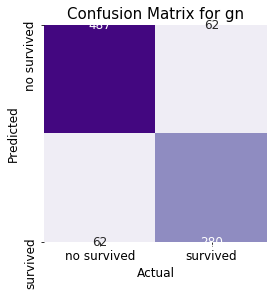

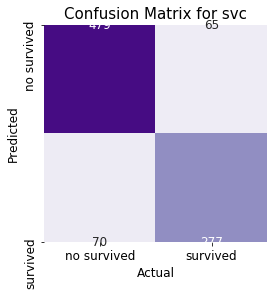

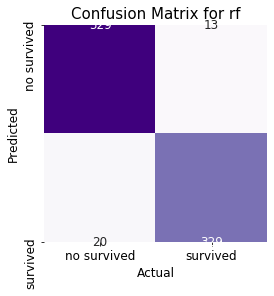

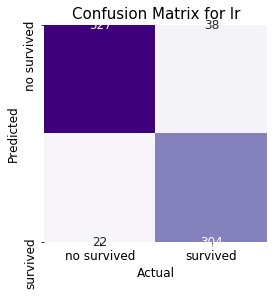

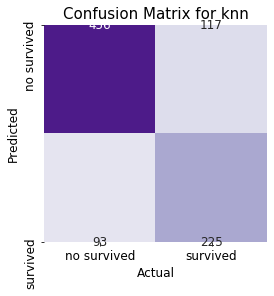

In [95]:
for name, model in models:
    y_pred = cross_val_predict(model, train_prepared, train.Survived, cv=5)
    conf_mat = confusion_matrix(train.Survived, y_pred)

    fig, ax = plt.subplots(figsize = (4,4))
    sns.heatmap(pd.DataFrame(conf_mat.T), annot=True, cmap="Purples", fmt='.0f', annot_kws={"size": 12, 'verticalalignment': 'center_baseline'}, vmin=0, vmax=500, cbar=False,
           xticklabels=["no survived","survived"], yticklabels=["no survived","survived"])
    plt.ylabel("Predicted", fontsize=12)
    plt.xlabel("Actual", fontsize=12)
    ax.set_xticklabels(["no survived","survived"], fontsize=12)
    ax.set_yticklabels(["no survived","survived"], fontsize=12)
    plt.title(f"Confusion Matrix for {name}", fontsize=15)

    plt.show()

I expect confusion marix to has the highest values on diagonal which is true in this example. Comparing each value across row and column provides four metrics called accuracy, precision, specifity, sensitivity.
Accuracy - number of proper predictions (from diagonal) vs all predicions.
Sensitivity (Recall) - share of correctly labeled 1 labels.
Specificity - share of correctly predicted 0 labels.
Precision - share of correctly predicted 1 labels across all predicted 1 labels.

In [96]:
for name, model in models:
    y_pred = cross_val_predict(model, train_prepared, train.Survived, cv=5)
    report = classification_report(train.Survived, y_pred, digits=3, output_dict=True)
    print(f"{name}:")
    print("Accuracy = {0:0.3f}".format(report["accuracy"]))
    print("Precision = {0:0.3f}".format(report["1"]["precision"]))
    print("Specificity = {0:0.3f}".format(report["0"]["recall"]))
    print("Sensitivity = {0:0.3f}".format(report["1"]["recall"]))
    print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))
    print('\n')

gn:
Accuracy = 0.861
Precision = 0.819
Specificity = 0.887
Sensitivity = 0.819
F1-score = 0.819


svc:
Accuracy = 0.848
Precision = 0.798
Specificity = 0.872
Sensitivity = 0.810
F1-score = 0.804


rf:
Accuracy = 0.963
Precision = 0.950
Specificity = 0.969
Sensitivity = 0.953
F1-score = 0.952


lr:
Accuracy = 0.933
Precision = 0.933
Specificity = 0.960
Sensitivity = 0.889
F1-score = 0.910


knn:
Accuracy = 0.764
Precision = 0.708
Specificity = 0.831
Sensitivity = 0.658
F1-score = 0.682


